In [1]:
using Pkg
Pkg.activate("../..")

  Activating project at `~/Documents/repos/nanoOpt.jl`


In [2]:
using Measures,LinearAlgebra,LazyGrids,LaTeXStrings,QuadGK,Plots

In [3]:
using FastGaussQuadrature

In [4]:
using TimerOutputs

In [5]:
const to = TimerOutput();

In [6]:
include("../../src/NanoOpt.jl")

KsspSlab (generic function with 1 method)

In [7]:
mat1 = material(1.0^2,1.0)
matSc = material(epstable("gold"),1.0)
mat2 = material(1.452^2,1.0);

In [8]:
matScatter = [mat1; matSc];

In [9]:
layer = layerstructure([mat1,mat2],[0.0,],"up");

In [10]:
w,d = 150.,17.
rc = 2.
Nc,Nw,Nd = 3,30,5
xC = (0.,d/2. +0.);

In [11]:
rod = Rod(w,d,rc,Nc,Nw,Nd,xC);

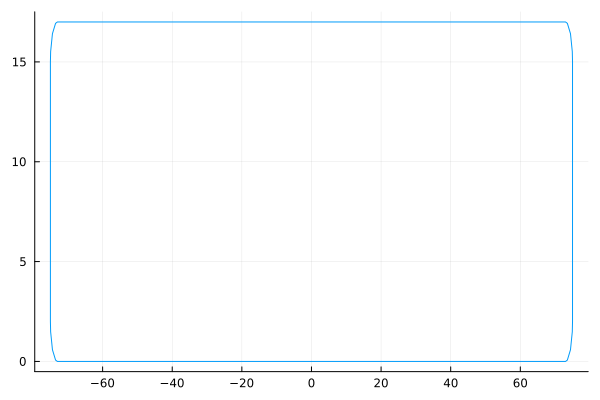

In [12]:
X,Y = getSurfPoints(rod)
plot(X,Y,legend=:none)

In [13]:
xm = (maximum(X)-minimum(X))+1;

In [14]:
yp = 2maximum(Y)+1
ym = 2minimum(Y);

In [15]:
dThr = 50.
m = 2

2

In [222]:
i = 1

k0 = 2π/700
n₁ = mat1.n(k0)
n₂ = mat2.n(k0)
r = 500.
α = 90

90

In [223]:
SParms = SommerfieldParams(layer,2k0);

In [224]:
@time Grf = GreenFunctions(matScatter,"layer";xP= (xm , 10), yP = (ym,yp,6), SParms = SParms);

  5.151025 seconds (27.93 M allocations: 1.146 GiB, 6.93% gc time)


In [225]:
@time H,ϕ = getHϕ(m,rod,k0,Grf,matSc.n,mat1.n,dThr,α,layer,"layer");

 19.255523 seconds (258.94 M allocations: 10.327 GiB, 11.95% gc time)


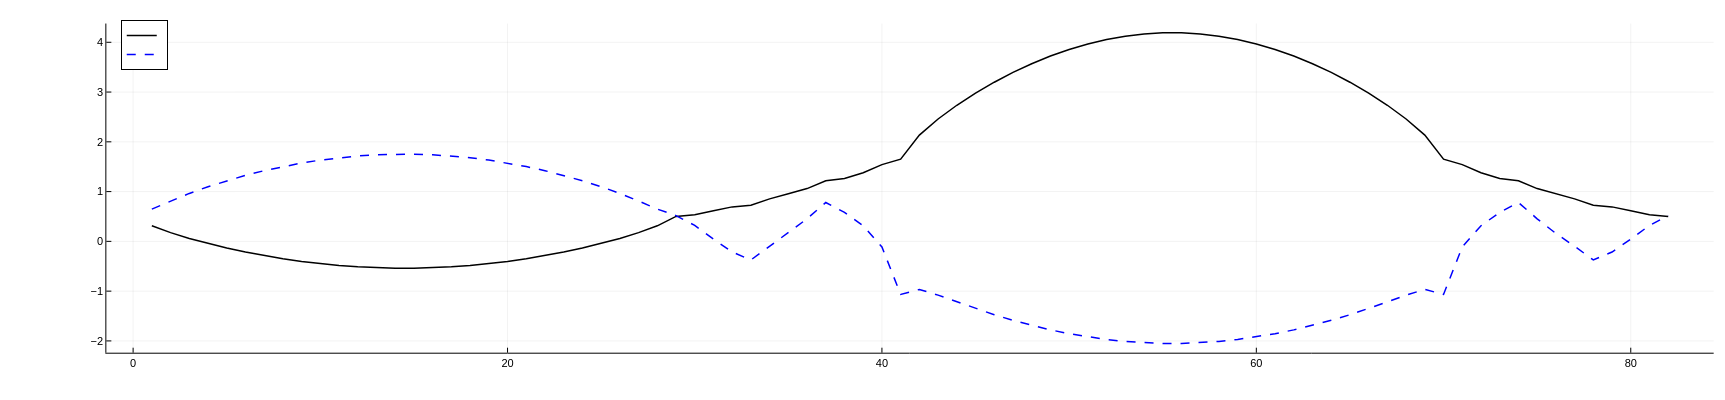

In [226]:
plotly()
plot(real.(H[:,3]),c=:black,lw=1.5,label=L"\Re\{ H(\mathbf{s}(t)) \}")
plot!(real.(ϕ[:,3])./k0,c=:blue,lw=1.5,ls=:dash,label=L"\Re\{ \phi(\mathbf{s}(t)) \}/ k_0",xlabel=L"t~[nm]",ylabel=L"Field",legend=:topleft)

# ========================================

In [50]:
function fCoef(kx::Number,ky1::Number,k0::Number,layer::layerstructure)
    rtC = rtcoeffs(layer,k0,[kx,],"up")
    rp = rtC.r.TM[1]
    
    f1 = (r::Vector{Float64}) ->  exp(-im*kx*r[1])*(exp(-im*ky1*r[2]) + rp*exp(im*ky1*r[2]))
    f2 = (r::Vector{Float64}) ->  exp(-im*kx*r[1])*(exp(-im*ky1*r[2]) - rp*exp(im*ky1*r[2]))
    
    f1,f2
end

function getHₛ(θ::Number,Rf::Number,ϕ::Matrix{ComplexF64},H::Matrix{ComplexF64},k0::Number,m::Int64,str::Structure,layer::layerstructure)
    _,SArr= getSvec(m,str)
    
    k₁ = layer.mat[1].k(k0)
    n₁ = layer.mat[1].n(k0)
    
    
    hₛF = 0.0*im
    if θ ≥ 0. && θ < π
        kx = k₁*cos(θ)
        ky1 = kyi(kx,k₁)
        
        f1,f2 = fCoef(kx,ky1,k0,layer)
    
        sum1 = 0.0*im
        for i ∈ 1:numEl(str)
            for v ∈ 0:m
                elI,_ =   quadgk(x -> ϕ[i,v+1]*f1(SQuad(x,i,str)) - H[i,v+1]*(nQuad(x,i,str)⋅[-im*kx*f1(SQuad(x,i,str)),-im*ky1*f2(SQuad(x,i,str))])*fpol(m,v,x),0,1)
                sum1 += Δ(i,SArr)*elI
            end
        end

        hₛF =  (-exp(im*k₁*Rf)/√(Rf))*(exp(-im*(π/4))/4)*√(2/(π*k₁))*sum1
        
    elseif θ < 0 && θ > -π
        
        kₙ = layer.mat[end].k(k0)
        nₙ = layer.mat[end].n(k0)
        
        kx = kₙ*cos(θ)
        ky1 = kyi(kx,k₁)
        kyn = kyi(kx,kₙ)
        rtC = rtcoeffs(layer,k0,[kx,],"up")
        tp = rtC.t.TM[1]
        
        
        sum1 = 0.0*im
        for i ∈ 1:numEl(str)
            for v ∈ 0:m
                elI,_ = quadgk(x -> exp(-im*kx*SQuad(x,i,str)[1])*exp(im*ky1*SQuad(x,i,str)[2])*(ϕ[i,v+1]-H[i,v+1]*(nQuad(x,i,str)⋅[-im*kx,im*ky1]))*fpol(m,v,x),0,1)
                sum1 += Δ(i,SArr)*elI
            end
        end
        
         hₛF = (-exp(im*kₙ*Rf)/√(Rf))*(exp(-im*(π/4))/4)*√(2/(π*kₙ))*(kyn/ky1)*tp*sum1
    end
    
    hₛF
end

getHₛ (generic function with 2 methods)

In [51]:
θ = π-0.01

3.1315926535897933

In [52]:
Rf = 500

500

In [53]:
getHₛ(θ,Rf,ϕ,H,k0,m,rod,layer)

-0.0008973052686209937 - 0.011887169015120607im

In [54]:
θA  = 0.1:0.1:π
θAn  = -0.1:-0.1:-π

-0.1:-0.1:-3.1

In [213]:
HsV = [getHₛ(θA[i],Rf,ϕ,H,k0,m,rod,layer) for i in eachindex(θA)];

In [214]:
HsVn = [getHₛ(θAn[i],Rf,ϕ,H,k0,m,rod,layer) for i in eachindex(θAn)];

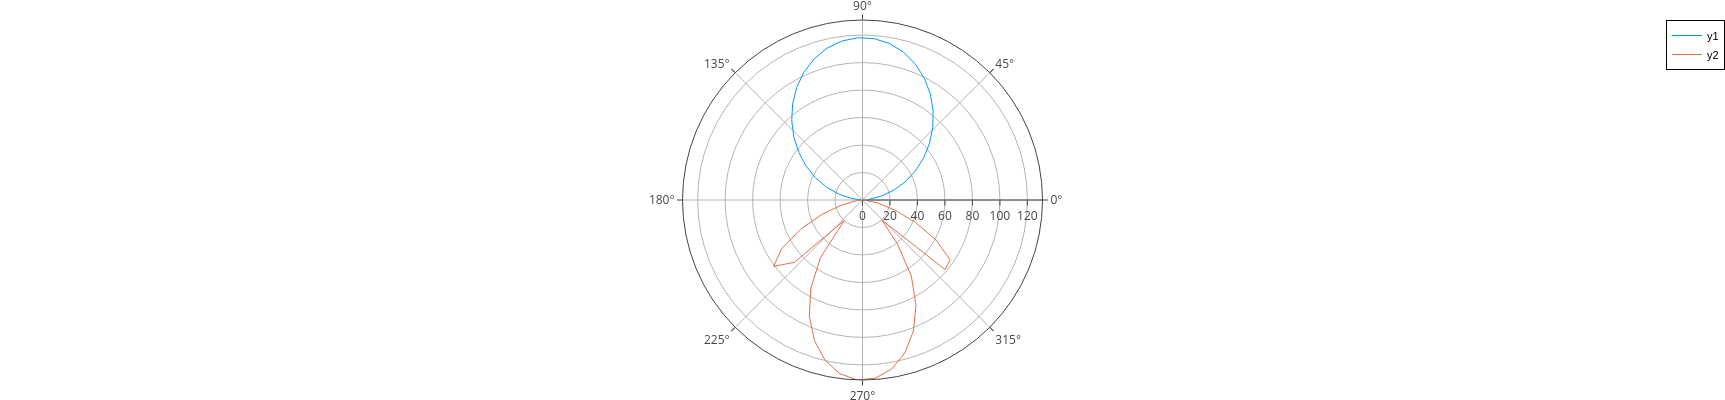

In [215]:
plot( θA,abs.(HsV).^2 .*Rf,proj=:polar)
plot!( θAn,abs.(HsVn).^2 .*Rf,proj=:polar)

In [216]:
abs.(HsV).^2 .*Rf

31-element Vector{Float64}:
   4.561166452863547
  13.445881333157445
  23.428467949053356
  33.582447923242576
  43.69602097325214
  53.73422788458622
  63.657573667040666
  73.36843375729039
  82.70474456768432
  91.45180761207251
  99.3614540766985
 106.17429538162128
 111.64280440119883
   ⋮
 102.34352103614998
  94.85879042337872
  86.42877223953923
  77.30909286792595
  67.73093844517449
  57.88026097035183
  47.88213342803223
  37.79745484879037
  27.65121159222739
  17.544959704090203
   8.00086717755165
   0.9690510600717875

In [217]:
sum(abs.(HsV))

10.772245392906168

In [218]:
sum(abs.(HsV).^2 * Rf)/length(HsV)

68.30350486218994

In [227]:
sum(abs.(HsVn).^2 * Rf)/length(HsV)

65.45604872937899

In [219]:
conj(getHₛ(90,Rf,ϕ,H,k0,m,rod,layer))

0.0 - 0.0im

In [220]:
rp,SArr= getSvec(m,rod);

In [221]:
δ(i::Int64,j::Int64) = i == j ? 1 : 0

δ(Sᵢ::Vector{Float64}) = [0.;1.]⋅Sᵢ == 0 ? 1 : 0

δ (generic function with 2 methods)

In [35]:
i,j, v,vl = 52,52,2,2

δ(SArr[i,v+1])

1

In [36]:
sV = SArr[i,v+1]

2-element Vector{Float64}:
 17.620689655172416
  0.0

In [37]:
constBel(i,j,v,vl,1,SArr[i,v+1],layer,k0,"Homo")

0.5

In [38]:
constBel(i,j,v,vl,1,SArr[i,v+1],layer,k0,"layer")

0.6782811462456697

In [39]:
ε₂ = layer.mat[end].ε(k0)
ε₁ = layer.mat[1].ε(k0);

In [40]:
0.5*δ(sV)*(ε₂-ε₁)/(ε₂+ε₁)+0.5

0.6782811462456697

In [41]:
intl =  BelementQuad(i,j,1,m,v,vl,k0,Grf,SArr,rp,rod,layer,"layer")

0.6782466725595282 + 0.00043491917743403727im

In [42]:
inth =  BelementQuad(i,j,1,m,v,vl,k0,Grf,SArr,rp,rod,layer,"Homo")

0.4999655263138585 + 0.00043491917743403727im

In [43]:
intl-inth

0.1782811462456697 + 0.0im

In [44]:
r = [1.0, 2.]

2-element Vector{Float64}:
 1.0
 2.0

In [45]:
r.*[1,-1]

2-element Vector{Float64}:
  1.0
 -2.0

In [46]:
mVec(r::Vector{Float64}) = r.*[1,-1]

mVec (generic function with 1 method)

In [47]:
vv = [2.3,4]

2-element Vector{Float64}:
 2.3
 4.0

In [48]:
mVec(vv)

2-element Vector{Float64}:
  2.3
 -4.0